## Advanced Lane Finding Project

The steps of this project are the following:

* Get challenging image frames from videos and add to test images.
* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.
* Apply the lane finding pipeline to 3 videos.

## Get challenging image frames from videos and add to test images.
<a id='ChallengeExtraction'></a>

In [6]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import os
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib qt
%matplotlib inline

# Extract frames from clip
def extract_frames(clip, times, imgdir):
    for t in times:
        imgpath = os.path.join(imgdir, '{}.jpg'.format(t))
        clip.save_frame(imgpath, t)
        
imgdir = 'test_images'

challenge_clip = VideoFileClip("challenge_video.mp4")
times = 1.1, 1.5, 2, 3, 4.4, 16
extract_frames(challenge_clip, times, imgdir)

hardchallenge_clip = VideoFileClip("harder_challenge_video.mp4")
times = 2.5, 5, 11
extract_frames(hardchallenge_clip, times, imgdir)
print("Done with image extraction.")

Done with image extraction.


## Compute the camera calibration using chessboard images
<a id='CameraCal'></a>

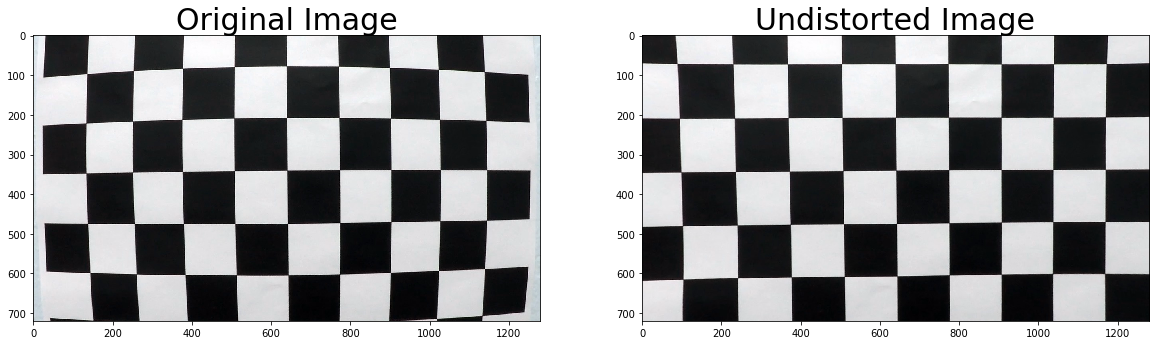

Done with camera calibration.


In [7]:
# Create undistorted directory, if it doesn't exist
undistorted_dir = 'output_images/undistorted/'
if not os.path.exists(undistorted_dir):
    os.mkdir(undistorted_dir)
    
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(8,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        #img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #cv2.imshow('img',img)
        #cv2.waitKey(500)

#cv2.destroyAllWindows()

# Load image to get image shape
img = cv2.imread(images[0])
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

#Test undistortion on an image
dst = cv2.undistort(img, mtx, dist, None, mtx)

filename = os.path.basename(images[0])
cv2.imwrite(undistorted_dir+filename,dst)
# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "camera_cal/wide_dist_pickle.p", "wb" ) )

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)
plt.show()
print("Done with camera calibration.")

## Apply a distortion correction to raw test images.
<a id='DistCorrTest'></a>

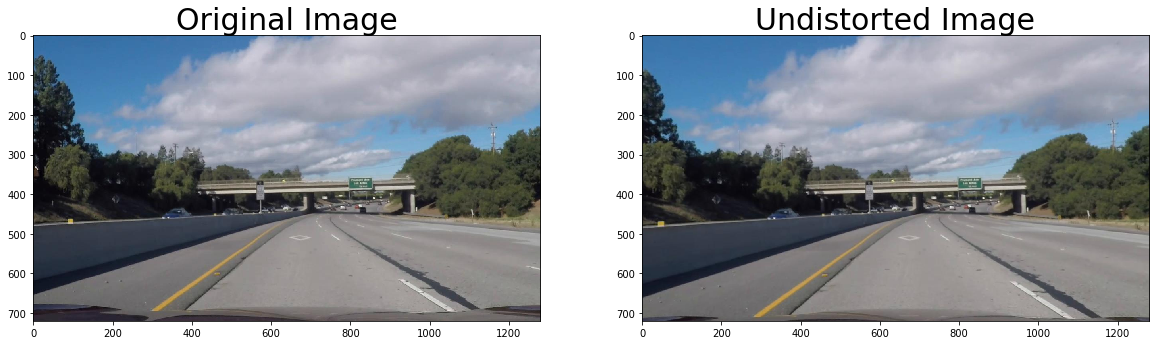

Done with distortion correction.


In [8]:
def undistort(img, mtx, dist):
    """ Distortion correct image, using camera calibration mtx and dist."""
    undist_img = cv2.undistort(img, mtx, dist, None, mtx)
    return undist_img

# Make a list of test images
testimages = glob.glob('test_images/*.jpg')

# set to 1 to display plots of all images, 0 to display only a single image
all_debug_plots = 0

idx = 0
# Step through the list and apply distortion correction
for fname in testimages:
    idx += 1
    img = cv2.imread(fname)
    filename = os.path.basename(fname)
    dst = undistort(img, mtx, dist)
    cv2.imwrite(undistorted_dir+filename,dst)
    if (all_debug_plots) or (idx == 1):
        # Visualize undistortion
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
        ax1.imshow(img)
        ax1.set_title('Original Image', fontsize=30)
        ax2.imshow(dst)
        ax2.set_title('Undistorted Image', fontsize=30)
        plt.show()
print("Done with distortion correction.")

## Use color transforms, gradients, etc., to create a thresholded binary image.
<a id='Thresh'></a>

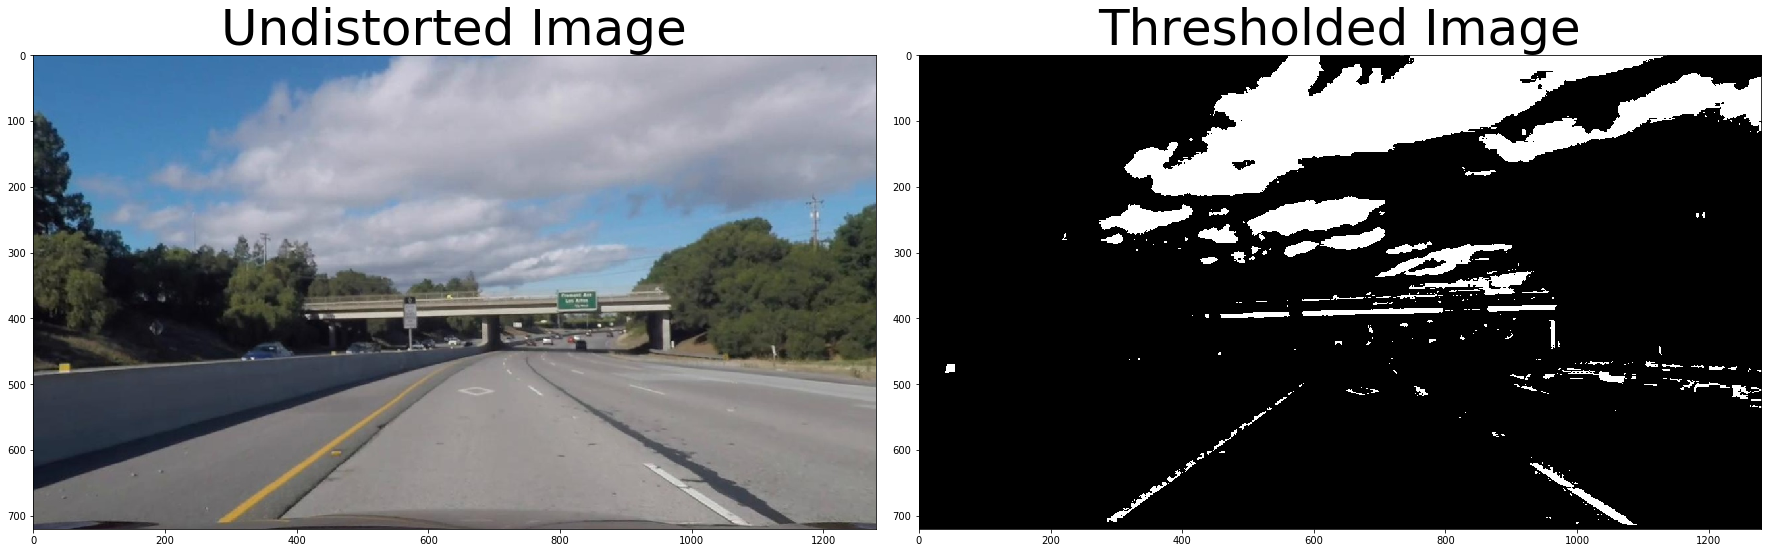

Done with thresholding.


In [9]:
from ipywidgets import interact, interactive, fixed

def thresholding(img, sx_thresh = (20, 90), l_thresh=(200, 255), h_thresh=(20, 35), v_thresh=(160,255)):
    # H and V are used to detect yellow
    # L is used to detect white
    image = np.copy(img)
    
    use_sobel = 0
    
    # Convert to gray
    gray = (cv2.cvtColor(image, cv2.COLOR_BGR2GRAY))
    #Take the derivative in x
    sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    # Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Convert to HSV color space and separate the H and V channels
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    h_channel = hsv[:,:,0]
    v_channel = hsv[:,:,2]
    
    v_avg = np.average(v_channel[450:600,500:800])
    #print(v_avg)
    
    if v_avg < 150:
        if v_avg < 100:
            use_sobel = 1
            v_thresh = (60, 255)
        l_thresh = (180,255)
            
    # Threshold h channel
    h_binary = np.zeros_like(h_channel)
    h_binary[(h_channel >= h_thresh[0]) & (h_channel <= h_thresh[1])] = 1
    
    # Threshold v channel
    v_binary = np.zeros_like(h_channel)
    v_binary[(v_channel >= v_thresh[0]) & (v_channel <= v_thresh[1])] = 1
    
    # Convert to HLS color space and separate the L channel
    hls = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
    l_channel = hls[:,:,1]
    l_channel = l_channel
    
    # Threshold l channel
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh[0]) & (l_channel <= l_thresh[1])] = 1  
    
    # Combine the binary thresholds
    combined_binary = np.zeros_like(l_binary)
    combined_binary[((sxbinary == 1) & (use_sobel == 1)) | (l_binary == 1) | ((h_binary == 1) & (v_binary == 1))] = 1
    return combined_binary

# Create warped directory, if it doesn't exist
thresh_dir = 'output_images/thresholded/'
if not os.path.exists(thresh_dir):
    os.mkdir(thresh_dir)

# set to 1 to display plots of all images, 0 to display only a single image
all_debug_plots = 0

# Make a list of undistorted images
undistimages = glob.glob(undistorted_dir+'*.jpg')

idx = 0
# Step through the list and apply thresholding
for fname in undistimages:
    idx += 1
    
    img = cv2.imread(fname)
    filename = os.path.basename(fname)
    thresholded = thresholding(img)
    cv2.imwrite(thresh_dir+filename,thresholded)
    cv2.imwrite(thresh_dir+"scaled_"+filename,thresholded*255)

    # Plot the original and warped images (convert back to RGB for matplotlib)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    #thresholded = cv2.cvtColor(thresholded,cv2.COLOR_GRAY2RGB)
    if all_debug_plots or idx == 1:        
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
        f.tight_layout()
        ax1.imshow(img)
        ax1.set_title('Undistorted Image', fontsize=50)
        ax2.imshow(thresholded, cmap = 'gray')
        ax2.set_title('Thresholded Image', fontsize=50)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
        plt.show()
        
print("Done with thresholding.")


## Apply a perspective transform to rectify binary image ("birds-eye view").
<a id='Warp'></a>

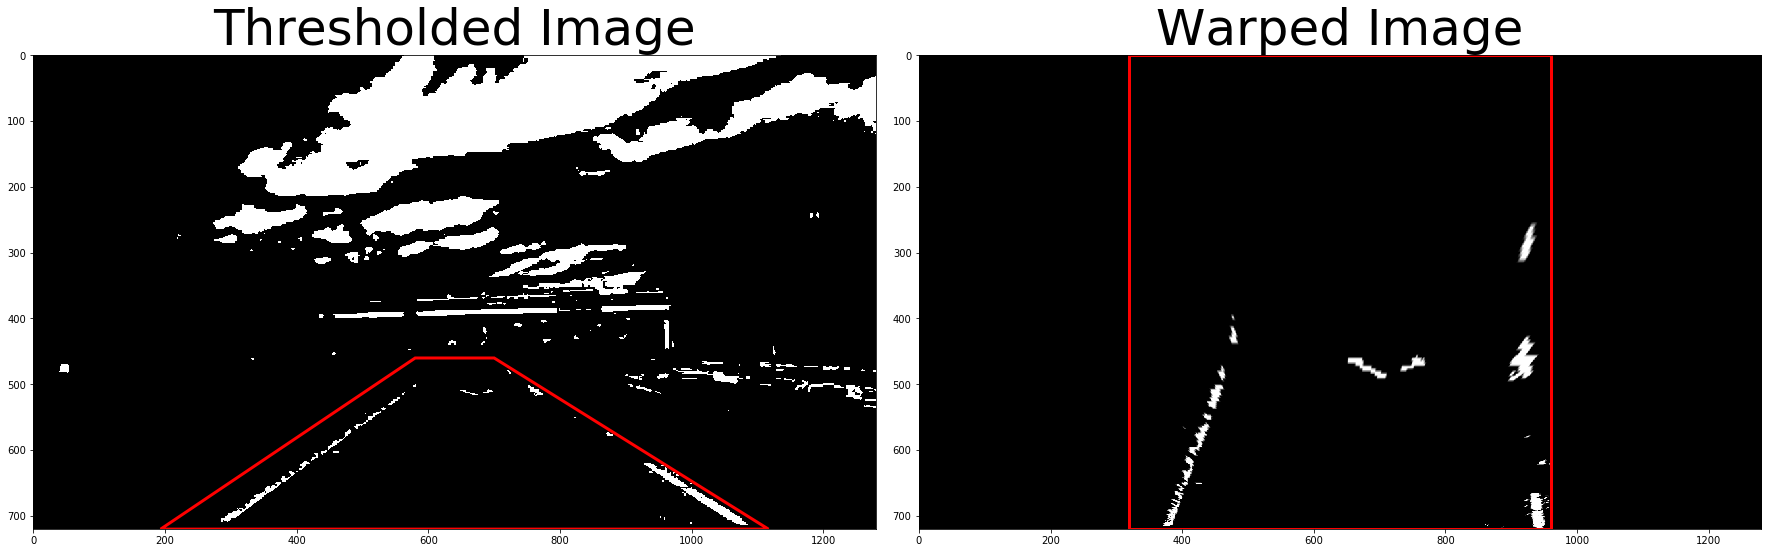

Done with perspective transform.


In [10]:
def warpimg(img, M):
    """ Warp image img using transform matrix M. """
    img_size = (img.shape[1], img.shape[0])
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped

def unwarpimg(img, Minv):
    """ Unwarp image img using transform matrix Minv. """
    img_size = (img.shape[1], img.shape[0])
    unwarped = cv2.warpPerspective(img, Minv, img_size, flags=cv2.INTER_LINEAR)
    return unwarped 

# Create warped directory, if it doesn't exist
warped_dir = 'output_images/warped/'
if not os.path.exists(warped_dir):
    os.mkdir(warped_dir)

# Make a list of thresholded images
threshimages = glob.glob(thresh_dir+'*.jpg')

# set to 1 to display plots of all images, 0 to display only a single image
all_debug_plots = 0

# get image size
img = cv2.imread(threshimages[0])
img_size = (img.shape[1], img.shape[0])
# source image offset from x-axis center
x_cent_off = 60
# source offset from y-axis center
y_cent_off = 100

# setup source and destination points for transform
src = np.float32(
[[(img_size[0] / 2) - x_cent_off, (img_size[1] / 2) + y_cent_off],
[((img_size[0] / 6) - 20), img_size[1]],
[(img_size[0] * 5 / 6) + 50, img_size[1]],
[(img_size[0] / 2) + x_cent_off, (img_size[1] / 2) + y_cent_off]])

dst = np.float32(
[[(img_size[0] / 4), 0],
[(img_size[0] / 4), img_size[1]],
[(img_size[0] * 3/4), img_size[1]],
[(img_size[0] * 3/4), 0]])

# get perspective transform matrix and inverse transform matrix
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)

idx = 0
# Step through the list and apply perspective transform
for fname in threshimages:
    idx += 1
    
    img = cv2.imread(fname)*255
    filename = os.path.basename(fname)
    warped = warpimg(img, M)
    cv2.imwrite(warped_dir+filename,warped)
    
    # Plot the original and warped images (convert back to RGB for matplotlib)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    warped = cv2.cvtColor(warped,cv2.COLOR_BGR2RGB)
    if all_debug_plots or idx == 1:        
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
        f.tight_layout()
        srcpoly = plt.Polygon(src, closed = True, fill = False, color = 'r', linewidth = 3)
        ax1.add_patch(srcpoly)
        ax1.imshow(img, cmap='gray')
        ax1.set_title('Thresholded Image', fontsize=50)
        dstpoly = plt.Polygon(dst, closed = True, fill = False, color = 'r', linewidth = 3)
        ax2.add_patch(dstpoly)
        ax2.imshow(warped, cmap='gray')
        ax2.set_title('Warped Image', fontsize=50)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
        plt.show()
        
print("Done with perspective transform.")

## Detect lane pixels and fit to find the lane boundary.
<a id='FindLane'></a>

In [17]:
def find_lane_pixels_box(binary_warped):
    # Take a histogram of the bottom half of the image
    width = binary_warped.shape[1]
    height = binary_warped.shape[0]
    bottom_half = np.copy(binary_warped[height//2:,:])
    # Crop the image
    bottom_half[:,0:np.int(width/5)] = 0
    bottom_half[:,np.int(width*4/5):] = 0
    # Generate histogram
    histogram = np.sum(bottom_half, axis = 0)
    
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 15
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 150
    # Set number of pixels to classify as a sharp turn
    sharpturn = 40
    
    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    left_inbounds = 1
    right_inbounds = 1
    # Step through the windows one by one
    for window in range(nwindows):
        
        # Identify window boundaries in x and y (and right and left) 
        win_xleft_low = leftx_current - margin  # Update this
        win_xleft_high = leftx_current + margin  # Update this
        win_xright_low = rightx_current - margin  # Update this
        win_xright_high = rightx_current + margin  # Update this
        win_y_high = binary_warped.shape[0] - window*window_height
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        
        if left_inbounds:
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),
            (win_xleft_high,win_y_high),(0,255,0), 2) 
            
            ### Identify the nonzero pixels in x and y within the window ###
            good_left_inds = np.nonzero((nonzeroy > win_y_low) & \
                            (nonzeroy < win_y_high) & \
                            (nonzerox > win_xleft_low) & \
                            (nonzerox < win_xleft_high))[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            
            ### If you found > minpix pixels, recenter next window ###
            ### (`right` or `leftx_current`) on their mean position ###
            if len(good_left_inds) > minpix:
                new_leftx = np.mean(nonzerox[good_left_inds])
                diff = new_leftx - leftx_current
                if (diff >= sharpturn):
                    leftx_current = np.int(new_leftx + diff)
                elif (diff <= -sharpturn):
                    leftx_current = np.int(new_leftx + diff)
                else:
                    leftx_current = np.int(new_leftx)
                
        if right_inbounds:
            cv2.rectangle(out_img,(win_xright_low,win_y_low),
            (win_xright_high,win_y_high),(0,255,0), 2) 


            good_right_inds = np.nonzero((nonzeroy > win_y_low) & \
                            (nonzeroy < win_y_high) & \
                            (nonzerox > win_xright_low) & \
                            (nonzerox < win_xright_high))[0]


            right_lane_inds.append(good_right_inds)


            if len(good_right_inds) > minpix:
                new_rightx = np.mean(nonzerox[good_right_inds])
                diff = new_rightx - rightx_current
                if (diff >= sharpturn):
                    rightx_current = np.int(new_rightx + diff)
                elif (diff <= -sharpturn):
                    rightx_current = np.int(new_rightx + diff)
                else:
                    rightx_current = np.int(new_rightx)
                    
        if win_xleft_low < 0 or win_xleft_high > binary_warped.shape[1]:
            left_inbounds = 0
        if win_xright_low < 0 or win_xright_high > binary_warped.shape[1]:
            right_inbounds = 0
            
    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

def find_lane_pixels_window(binary_warped, left_fit, right_fit, margin):

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###

    left_fitx = left_fit[0]*nonzeroy**2 + left_fit[1]*nonzeroy + left_fit[2]
    right_fitx = right_fit[0]*nonzeroy**2 + right_fit[1]*nonzeroy + right_fit[2]
    
    left_lane_inds = np.nonzero(np.abs(left_fitx - nonzerox) < margin)[0]
    right_lane_inds = np.nonzero(np.abs(right_fitx - nonzerox) < margin)[0]
                    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    left_lane_inds = np.nonzero(np.abs(left_fitx - nonzerox) < margin)[0]
    right_lane_inds = np.nonzero(np.abs(right_fitx - nonzerox) < margin)[0]
    
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    return leftx, lefty, rightx, righty, out_img

def fit_poly(img_shape, leftx, lefty, rightx, righty):
    ### Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])

    ### Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Limit in case fit gives out of bounds values
    left_fitx = np.clip(left_fitx, a_min = 0, a_max = img_shape[1]-1) 
    right_fitx = np.clip(right_fitx, a_min = 0, a_max = img_shape[1]-1)

    return left_fit, right_fit, left_fitx, right_fitx, ploty

def fit_poly_cr(leftx, lefty, rightx, righty):
    # Calculate fit in terms of meters
    ym_per_pix = 3.048/95 # meters per pixel in y dimension
    xm_per_pix = 3.7/640 # meters per pixel in x dimension
    
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    return left_fit_cr, right_fit_cr

def fit_polynomial_window(binary_warped, left_fit, right_fit):
    # HYPERPARAMETER
    # The width of the margin around the previous polynomial to search
    margin = 80
    
    # Find lane pixels using window
    leftx, lefty, rightx, righty, out_img = find_lane_pixels_window(binary_warped, left_fit, right_fit, margin)
    
    left_fit_new, right_fit_new, left_fit_cr, right_fit_cr = (None, None, None, None)
    result = out_img
    if (leftx is not None and rightx is not None and leftx.size != 0 and rightx.size != 0):
        # Fit new polynomials
        left_fit_new, right_fit_new, left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)

        # Calculate fit in terms of meters
        left_fit_cr, right_fit_cr = fit_poly_cr(leftx, lefty, rightx, righty)

        ## Visualization ##    
        window_img = np.zeros_like(out_img)

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

        # Plots the left and right polynomials on the lane lines
        result[ploty.astype(int), left_fitx.astype(int)] = [255, 255, 0]
        result[ploty.astype(int), right_fitx.astype(int)] = [255, 255, 0]

        ## End visualization steps ##
    
    return left_fit_new, right_fit_new, left_fit_cr, right_fit_cr, result

def fit_polynomial_box(binary_warped):
    
    # Find our lane pixels using box
    leftx, lefty, rightx, righty, out_img = find_lane_pixels_box(binary_warped)
    
    left_fit, right_fit, left_fit_cr, right_fit_cr = (None, None, None, None)
    
    if (leftx is not None and rightx is not None and leftx.size != 0 and rightx.size != 0):
        # Calculate fit in terms of pixels
        left_fit, right_fit, left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
        # Calculate fit in terms of meters
        left_fit_cr, right_fit_cr = fit_poly_cr(leftx, lefty, rightx, righty)
        
        ## Visualization ##
        # Colors in the left and right lane regions
        out_img[lefty, leftx] = [255, 0, 0]
        out_img[righty, rightx] = [0, 0, 255]

        # Plots the left and right polynomials on the lane lines
        out_img[ploty.astype(int), left_fitx.astype(int)] = [255, 255, 0]
        out_img[ploty.astype(int), right_fitx.astype(int)] = [255, 255, 0]
    
    return left_fit, right_fit, left_fit_cr, right_fit_cr, out_img


## Determine the curvature of the lane and vehicle position with respect to center.
<a id='FindCurve'></a>

In [18]:
def measure_curvature_real(img, left_fit_cr, right_fit_cr):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 3.048/95 # meters per pixel in y dimension
    xm_per_pix = 3.7/640 # meters per pixel in x dimension
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = ym_per_pix*(img.shape[0]-1)
    
    ##### Calculation of R_curve (radius of curvature) #####
    left_curverad = (1+(2*left_fit_cr[0]*y_eval+left_fit_cr[1])**2)**1.5/np.abs(2*left_fit_cr[0])
    right_curverad = (1+(2*right_fit_cr[0]*y_eval+right_fit_cr[1])**2)**1.5/np.abs(2*right_fit_cr[0])
    curverad = (left_curverad+right_curverad)/2
    
    # Calculate center offset
    car_position = img.shape[1]/2*xm_per_pix
    left_lane_pos = left_fit_cr[0]*y_eval**2 + left_fit_cr[1]*y_eval + left_fit_cr[2]
    right_lane_pos = right_fit_cr[0]*y_eval**2 + right_fit_cr[1]*y_eval + right_fit_cr[2]
    lane_center_position = (right_lane_pos + left_lane_pos) /2
    center_offset = (car_position - lane_center_position)
    
    return left_curverad, right_curverad, curverad, center_offset

## Warp the detected lane boundaries back onto the original image.
<a id='DrawLane'></a>

In [1]:
def draw_lane_bounds(warped, undist, left_fit, right_fit, Minv):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    height, width = warped.shape
    ploty = np.linspace(0, height-1, num=height)# to cover same y-range as image
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (width, height)) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)

    return result

## Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.
<a id='DrawData'></a>

In [20]:
def draw_data(img, curve_rad, center_offset):
    new_img = np.copy(img)
    height = new_img.shape[0]
    
    # Curvature radius
    font = cv2.FONT_HERSHEY_DUPLEX
    text = 'Curvature radius: ' + '{:05.2f}'.format(curve_rad) + 'm'
    cv2.putText(new_img, text, (40,70), font, 1.5, (0,0,0), 3, cv2.LINE_AA)
    direction = ''
    
    # Center offset
    if center_offset > 0:
        direction = 'right'
    elif center_offset < 0:
        direction = 'left'    
    abs_center_offset = abs(center_offset)
    text = '{:04.3f}'.format(abs_center_offset) + 'm ' + direction + ' of center'
    cv2.putText(new_img, text, (40,150), font, 1.5, (0,0,0), 3, cv2.LINE_AA)
    return new_img

def draw_diag_data(img, LeftLane, RightLane):
    new_img = np.copy(img)
    height = new_img.shape[0]
    
    # Left lane good fits count
    font = cv2.FONT_HERSHEY_DUPLEX
    text = 'Left Good Fits: ' + '{:d}'.format(len(LeftLane.current_fit))
    cv2.putText(new_img, text, (40,200), font, 1, (0,0,0), 2, cv2.LINE_AA)
    direction = ''
    
    # Right lane good fits count
    text = 'Right Good Fits: ' + '{:d}'.format(len(RightLane.current_fit))
    cv2.putText(new_img, text, (40,250), font, 1, (0,0,0), 2, cv2.LINE_AA)
    return new_img

def check_fit(img, left_fit, right_fit):

    max_x_int_diff = 750
    min_x_int_diff = 300
    diverging_diff = 200
    
    if left_fit is not None and right_fit is not None:
        x_max = img.shape[1]
        y_max = img.shape[0]
        
        # calculate x-intercept and the difference between them
        left_fit_x_int = left_fit[0]*y_max**2 + left_fit[1]*y_max + left_fit[2]
        right_fit_x_int = right_fit[0]*y_max**2 + right_fit[1]*y_max + right_fit[2]
        x_int_diff = right_fit_x_int-left_fit_x_int
        
        # calculate difference between fits when y = 0, which is just the constant parameter
        # limit it to between 0 and x_max in case of very curvy road
        left_fit_x_at_zero = min(x_max,max(0, left_fit[2]))
        right_fit_x_at_zero = min(x_max,max(0, right_fit[2]))
        x_diff_at_zero = right_fit_x_at_zero - left_fit_x_at_zero
        
        # Check if the x-intercept of the left and right lane are too far apart or too close
        if x_int_diff > max_x_int_diff or x_int_diff < min_x_int_diff:
            left_fit = None
            right_fit = None
            
        # Check if the difference at y = 0 is negative (meaning line are crossing)
        if x_diff_at_zero < 0:
            left_fit = None
            right_fit = None
            
        # Check if difference at y = 0 is much greater than difference at x-intercept
        # This would mean lines are diverging
        if x_diff_at_zero - x_int_diff > diverging_diff:
            left_fit = None
            right_fit = None
            
    return left_fit, right_fit

## Test lane detection and final image output

Left curvature radius: 579.4043132599753 meters
Right curvature radius: 191.5203867809774 meters
Left fit coefficients: [-1.54845750e-04 -1.75820296e-01  5.81272034e+02]
Right fit coefficients: [ 4.66225388e-04 -4.24314104e-01  1.00642188e+03]
Good Fit


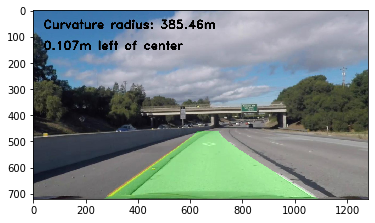

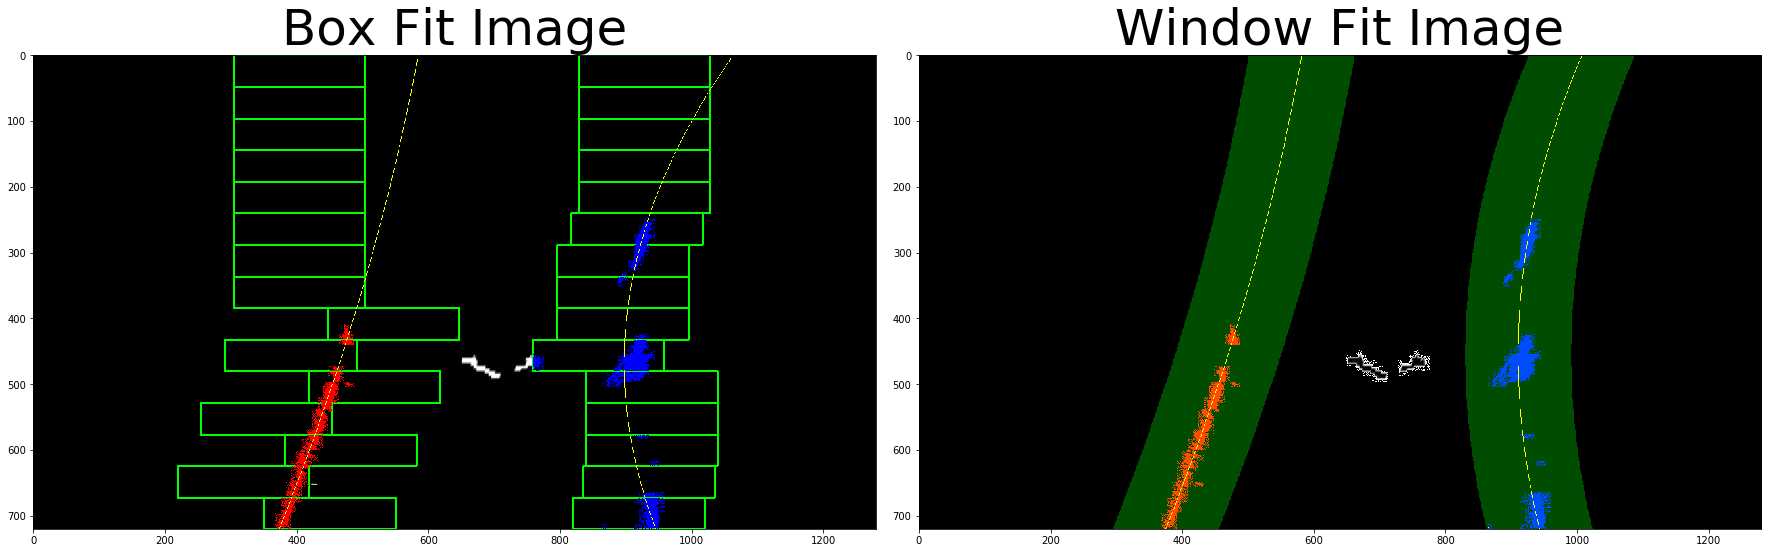

In [34]:
# Make a list of warped images
warpedimages = glob.glob(warped_dir+'*.jpg')

# set to 1 to display plots of all images, 0 to display only a single image
all_debug_plots = 0

idx = 0
# Step through the list and apply perspective transform
for fname in warpedimages:
    idx += 1
    
    if all_debug_plots or idx == 1:
        binary = cv2.imread(fname, cv2.IMREAD_GRAYSCALE)
        undist = cv2.imread(undistimages[idx-1])
        filename = os.path.basename(fname)

        left_fit, right_fit, left_fit_cr, right_fit_cr, box_img = fit_polynomial_box(binary)
        left_fit, right_fit, left_fit_cr, right_fit_cr, window_img = fit_polynomial_window(binary, left_fit, right_fit)
        left_curv_rad, right_curv_rad, curve_rad, center_offset = measure_curvature_real(binary, left_fit_cr, right_fit_cr)
        print("Left curvature radius: " + str(left_curv_rad) + " meters")
        print("Right curvature radius: " + str(right_curv_rad) + " meters")

        unwarped_img = draw_lane_bounds(binary, undist, left_fit, right_fit, Minv)
        final_img = draw_data(unwarped_img, curve_rad, center_offset)
        plt.imshow(cv2.cvtColor(final_img, cv2.COLOR_BGR2RGB))

        print("Left fit coefficients: "+ str(left_fit))
        print("Right fit coefficients: "+ str(right_fit))
        left_fit, right_fit = check_fit(binary, left_fit, right_fit)
        if left_fit is None or right_fit is None:
            print("Bad Fit")
        else:
            print("Good Fit")
        
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
        f.tight_layout()
        ax1.imshow(box_img)
        ax1.set_title('Box Fit Image', fontsize=50)
        ax2.imshow(window_img)
        ax2.set_title('Window Fit Image', fontsize=50)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
        plt.show()

## Image processing pipeline
<a id='Pipeline'></a>

In [26]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fits
        self.current_fit = []  
        #radius of curvature of the line in some units
        self.radius_of_curvature = 0
        #radius of curvature of the most recent fits
        self.radius_recent = []
        #distance in meters of vehicle center from the line
        self.center_offset = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        
    def updatefit(self, fit, curv_rad, center_off):
        avg_count = 10
        if fit is not None:
            if self.best_fit is not None:
                self.diffs = abs(fit - self.best_fit)
                if self.diffs[0] < 0.0004 and self.diffs[1] < 0.4 and self.diffs[2] < 300:
                    self.detected = True
                else:
                    self.detected = False
            else:
                self.detected = True
            
            if self.detected == True:
                self.current_fit.append(fit)
                self.center_offset = center_off
                self.radius_recent.append(curv_rad)
                
                if len(self.current_fit) > (avg_count-1):
                    self.current_fit.pop(0)
                if len(self.radius_recent) > (avg_count-1):
                    self.radius_recent.pop(0)
            else:
                if len(self.current_fit) > 0:
                    self.current_fit.pop(0)
                if len(self.radius_recent) > 0:
                    self.radius_recent.pop(0) 
                    
            if len(self.current_fit) > 0:
                self.best_fit = np.average(self.current_fit, axis=0)
            else:
                self.best_fit = fit
                
            if len(self.radius_recent) > 0:
                self.radius_of_curvature = np.average(self.radius_recent, axis=0)
            else:
                self.radius_of_curvature = curv_rad    

        else:
            self.detected = False
            
            if len(self.current_fit) > 0:
                self.current_fit.pop(0)
            #if len(self.current_fit) > 0:
            #    self.best_fit = np.average(self.current_fit, axis=0)
            
            if len(self.radius_recent) > 0:
                self.radius_recent.pop(0)    
            #if len(self.radius_recent) > 0:
            #    self.radius_of_curvature = np.average(self.radius_recent, axis=0)
            

def process_image(img):
    
    show_diag_info = 0
    
    # Convert to BGR
    img_bgr = cv2.cvtColor(img,cv2.COLOR_RGB2BGR)
    # Undistort
    undist = undistort(img_bgr, mtx, dist)
    # Apply thresholding
    thresholded = thresholding(undist)
    # Warp to birds eye view
    binary = warpimg(thresholded, M)
    # Find lane lines and polynomial fit
    if LeftLane.detected and RightLane.detected:
        left_fit, right_fit, left_fit_cr, right_fit_cr, window_img = fit_polynomial_window(binary, LeftLane.best_fit, RightLane.best_fit)
    else:
        left_fit, right_fit, left_fit_cr, right_fit_cr, box_img = fit_polynomial_box(binary)
    # Calculate the curvature radius and center offset
    if left_fit_cr is not None and right_fit_cr is not None:
        left_curv_rad, right_curv_rad, curve_rad, center_offset = measure_curvature_real(binary, left_fit_cr, right_fit_cr)
    else:
        left_curv_rad = 0
        right_curv_rad = 0
        curve_rad = 0
        center_offset = 0
    
    # Sanity check the fit
    left_fit, right_fit = check_fit(binary, left_fit, right_fit)
    
    # Update the fit and curvature
    LeftLane.updatefit(left_fit, left_curv_rad, center_offset)
    RightLane.updatefit(right_fit, right_curv_rad, center_offset)
        
    if LeftLane.best_fit is not None and RightLane.best_fit is not None:
        curve_radius = (LeftLane.radius_of_curvature + RightLane.radius_of_curvature)/2
        # Unwarp and draw lane boundaries on the undistorted image
        unwarped_img = draw_lane_bounds(binary, undist, LeftLane.best_fit, RightLane.best_fit, Minv)
        # Draw curvature radius and center offset data
        data_img = draw_data(unwarped_img, curve_radius, LeftLane.center_offset)
        if show_diag_info:
            # Draw Diag Data
            diag_img = draw_diag_data(data_img, LeftLane, RightLane)
            # Convert back to RGB
            final_img = cv2.cvtColor(diag_img, cv2.COLOR_BGR2RGB)
        else:
            final_img = cv2.cvtColor(data_img, cv2.COLOR_BGR2RGB)
    else:
        final_img = img
    
    return final_img

## Process a project video.

In [27]:
LeftLane = Line()
RightLane = Line()

# Create output videos directory, if it doesn't exist
outvid_dir = 'output_videos/'
if not os.path.exists(outvid_dir):
    os.mkdir(outvid_dir)
    
project_output = outvid_dir + 'project_video.mp4'
##clip1 = VideoFileClip("project_video.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
proj_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time proj_clip.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video output_videos/project_video.mp4
[MoviePy] Writing video output_videos/project_video.mp4


100%|█████████▉| 1260/1261 [03:08<00:00,  6.45it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video.mp4 

Wall time: 3min 9s


## Play the output video inline.

In [28]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))

## Process a challenge video.

In [29]:
LeftLane = Line()
RightLane = Line()

# Create output videos directory, if it doesn't exist
outvid_dir = 'output_videos/'
if not os.path.exists(outvid_dir):
    os.mkdir(outvid_dir)
    
challenge_output = outvid_dir + 'challenge_video.mp4'
##clip1 = VideoFileClip("challenge_video.mp4").subclip(0,5)
clip2 = VideoFileClip("challenge_video.mp4")
challenge_clip = clip2.fl_image(process_image) #NOTE: this function expects color images!!
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video output_videos/challenge_video.mp4
[MoviePy] Writing video output_videos/challenge_video.mp4


100%|██████████| 485/485 [01:07<00:00,  7.20it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/challenge_video.mp4 

Wall time: 1min 8s


## Play the output video inline.

In [30]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

## Process a harder challenge video.

In [31]:
LeftLane = Line()
RightLane = Line()

# Create output videos directory, if it doesn't exist
outvid_dir = 'output_videos/'
if not os.path.exists(outvid_dir):
    os.mkdir(outvid_dir)
    
hardchallenge_output = outvid_dir + 'harder_challenge_video.mp4'
##clip1 = VideoFileClip("harder_challenge_video.mp4").subclip(0,5)
clip3 = VideoFileClip("harder_challenge_video.mp4")
hardchallenge_clip = clip3.fl_image(process_image) #NOTE: this function expects color images!!
%time hardchallenge_clip.write_videofile(hardchallenge_output, audio=False)


[MoviePy] >>>> Building video output_videos/harder_challenge_video.mp4
[MoviePy] Writing video output_videos/harder_challenge_video.mp4


100%|█████████▉| 1199/1200 [03:27<00:00,  6.47it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/harder_challenge_video.mp4 

Wall time: 3min 28s


## Play the output video inline.

In [32]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(hardchallenge_output))